In [ ]:
# 📦 Install dependencies
!pip install -q optbinning tensorflow_decision_forests

In [ ]:
# 📚 Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from optbinning import BinningProcess
import tensorflow as tf
import tensorflow_decision_forests as tfdf

In [ ]:
# 📂 Filepaths
train_path = "/content/Credit_Card_train.csv"
test_path = "/content/Credit_Card_test.csv"

# 📥 Load datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# 🎯 Rename target for consistency
train_df.rename(columns={"default.payment.next.month": "target"}, inplace=True)

In [ ]:
# 🧹 Optional: drop ID columns if any
id_cols = [col for col in ['ID', 'id'] if col in train_df.columns]
if id_cols:
    train_df.drop(columns=id_cols, inplace=True)
    test_df.drop(columns=id_cols, inplace=True)

In [ ]:
# ➗ Train/Val Split for local validation
X = train_df.drop(columns="target")
y = train_df["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
from optbinning import BinningProcess

bp = BinningProcess(
    variable_names=X.columns.tolist(),
    selection_criteria={"iv": {"min": 0.02}}  # Choose variables with IV ≥ 0.02
)
bp.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

BinningProcess(selection_criteria={'iv': {'min': 0.02}},
               variable_names=['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE',
                               'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4',
                               'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
                               'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
                               'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
                               'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])

In [ ]:
X_train_woe = bp.transform(X_train)
X_val_woe = bp.transform(X_val)
X_test_woe = bp.transform(test_df)

In [ ]:
# 🪄 Convert to TF-friendly datasets
def df_to_tf(data, labels=None):
    if labels is not None:
        return tf.data.Dataset.from_tensor_slices((dict(data), labels)).batch(128)
    else:
        return tf.data.Dataset.from_tensor_slices(dict(data)).batch(128)

train_ds = df_to_tf(X_train_woe, y_train)
val_ds = df_to_tf(X_val_woe, y_val)
test_ds = df_to_tf(X_test_woe)

In [ ]:
# 🌳 Train TensorFlow Decision Forest model
model = tfdf.keras.GradientBoostedTreesModel(max_depth=6, num_trees=100)
model.fit(train_ds)

# 📊 Evaluate on validation set
print("\n📈 Validation Metrics:")
model.evaluate(val_ds)

# 🔮 Predict on test set
predictions = model.predict(test_ds).flatten()
predictions

Use /tmp/tmpp4qq6nz2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:07.224787. Found 16000 examples.
Training model...
Model trained in 0:00:01.726814
Compiling model...
Model compiled.

📈 Validation Metrics:
79/79 [==============================] - 0s 3ms/step


array([0.1228836 , 0.61222464, 0.14961827, ..., 0.69438297, 0.12149568,
       0.12424579], dtype=float32)

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

y_val_pred = model.predict(df_to_tf(X_val_woe)).flatten()
auc = roc_auc_score(y_val, y_val_pred)
accuracy = accuracy_score(y_val, y_val_pred > 0.5)

print(f"AUC: {auc:.4f} | Accuracy: {accuracy:.4f}")

32/32 [==============================] - 0s 2ms/step
AUC: 0.7657 | Accuracy: 0.8067


In [ ]:
iv_df = pd.DataFrame(bp.summary())
iv_df.head()

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,LIMIT_BAL,numerical,OPTIMAL,True,9,0.168409,0.020749,0.227259,0.027427
1,SEX,numerical,OPTIMAL,False,2,0.007365,0.00092,0.041969,0.019376
2,EDUCATION,numerical,OPTIMAL,False,3,0.012784,0.001597,0.05742,0.029356
3,MARRIAGE,numerical,OPTIMAL,False,2,0.005834,0.000729,0.038074,0.016054
4,AGE,numerical,OPTIMAL,True,9,0.030776,0.003837,0.097093,0.002793


In [ ]:
top_iv = iv_df[["name", "iv"]].sort_values(by="iv", ascending=False)
top_iv.head(10)

,name,iv
5,PAY_0,0.849124
6,PAY_2,0.532491
7,PAY_3,0.390223
8,PAY_4,0.3405
9,PAY_5,0.331094
10,PAY_6,0.253097
17,PAY_AMT1,0.171205
0,LIMIT_BAL,0.168409
18,PAY_AMT2,0.15522
20,PAY_AMT4,0.117686


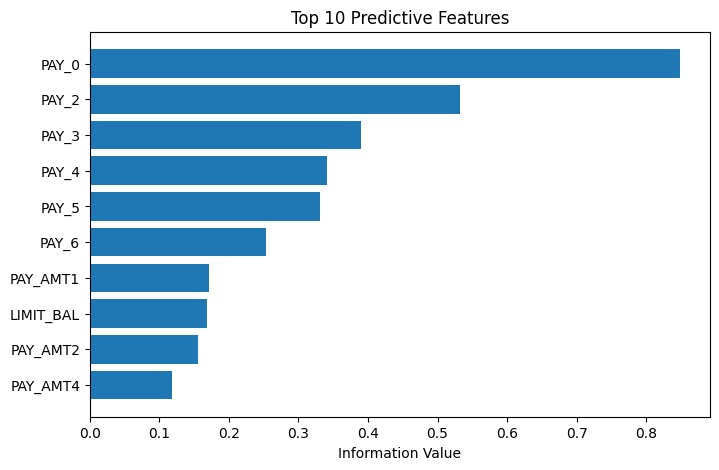

In [ ]:
import matplotlib.pyplot as plt

top_iv = iv_df.sort_values(by="iv", ascending=False).head(10)
plt.figure(figsize=(8,5))
plt.barh(top_iv["name"], top_iv["iv"])
plt.gca().invert_yaxis()
plt.xlabel("Information Value")
plt.title("Top 10 Predictive Features")
plt.show()

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:   6%|▌         | 3/50 [00:00<?, ?it/s]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  10%|█         | 5/50 [00:13<01:04,  1.43s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  12%|█▏        | 6/50 [00:16<01:32,  2.10s/it]

12/12 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  14%|█▍        | 7/50 [00:20<02:02,  2.84s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  16%|█▌        | 8/50 [00:22<01:55,  2.74s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  18%|█▊        | 9/50 [00:25<01:52,  2.75s/it]

12/12 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  20%|██        | 10/50 [00:28<01:51,  2.80s/it]

12/12 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  22%|██▏       | 11/50 [00:33<02:08,  3.29s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  24%|██▍       | 12/50 [00:35<01:58,  3.11s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  26%|██▌       | 13/50 [00:38<01:53,  3.07s/it]

11/11 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  28%|██▊       | 14/50 [00:41<01:48,  3.00s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  30%|███       | 15/50 [00:45<01:58,  3.39s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  32%|███▏      | 16/50 [00:48<01:48,  3.18s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  34%|███▍      | 17/50 [00:51<01:43,  3.12s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  36%|███▌      | 18/50 [00:54<01:38,  3.07s/it]

10/10 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  38%|███▊      | 19/50 [00:58<01:44,  3.37s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  40%|████      | 20/50 [01:01<01:38,  3.28s/it]

11/11 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  42%|████▏     | 21/50 [01:04<01:31,  3.15s/it]

10/10 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  44%|████▍     | 22/50 [01:07<01:25,  3.05s/it]

11/11 [==============================] - 0s 9ms/step


PermutationExplainer explainer:  46%|████▌     | 23/50 [01:11<01:30,  3.36s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  48%|████▊     | 24/50 [01:14<01:22,  3.19s/it]

12/12 [==============================] - 0s 10ms/step


PermutationExplainer explainer:  50%|█████     | 25/50 [01:17<01:18,  3.15s/it]

12/12 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  52%|█████▏    | 26/50 [01:19<01:12,  3.01s/it]

11/11 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  54%|█████▍    | 27/50 [01:23<01:13,  3.20s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  56%|█████▌    | 28/50 [01:27<01:13,  3.33s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  58%|█████▊    | 29/50 [01:30<01:07,  3.24s/it]

11/11 [==============================] - 0s 6ms/step


PermutationExplainer explainer:  60%|██████    | 30/50 [01:33<01:02,  3.15s/it]

11/11 [==============================] - 0s 8ms/step


PermutationExplainer explainer:  62%|██████▏   | 31/50 [01:36<01:01,  3.26s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  64%|██████▍   | 32/50 [01:39<00:58,  3.27s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  66%|██████▌   | 33/50 [01:42<00:53,  3.16s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  68%|██████▊   | 34/50 [01:45<00:49,  3.08s/it]

11/11 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  70%|███████   | 35/50 [01:50<00:53,  3.59s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  72%|███████▏  | 36/50 [01:53<00:49,  3.52s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  74%|███████▍  | 37/50 [01:56<00:43,  3.36s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  76%|███████▌  | 38/50 [01:59<00:39,  3.26s/it]

11/11 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  78%|███████▊  | 39/50 [02:04<00:39,  3.60s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  80%|████████  | 40/50 [02:07<00:33,  3.38s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  82%|████████▏ | 41/50 [02:09<00:28,  3.18s/it]

12/12 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  84%|████████▍ | 42/50 [02:12<00:25,  3.15s/it]

11/11 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  86%|████████▌ | 43/50 [02:16<00:23,  3.43s/it]

10/10 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  88%|████████▊ | 44/50 [02:19<00:19,  3.21s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  90%|█████████ | 45/50 [02:22<00:16,  3.20s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  92%|█████████▏| 46/50 [02:25<00:12,  3.13s/it]

11/11 [==============================] - 0s 12ms/step


PermutationExplainer explainer:  94%|█████████▍| 47/50 [02:30<00:10,  3.55s/it]

11/11 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  96%|█████████▌| 48/50 [02:32<00:06,  3.25s/it]

12/12 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  98%|█████████▊| 49/50 [02:36<00:03,  3.28s/it]

11/11 [==============================] - 0s 14ms/step


PermutationExplainer explainer: 100%|██████████| 50/50 [02:39<00:00,  3.15s/it]

12/12 [==============================] - 0s 9ms/step


PermutationExplainer explainer: 51it [02:43,  3.40s/it]


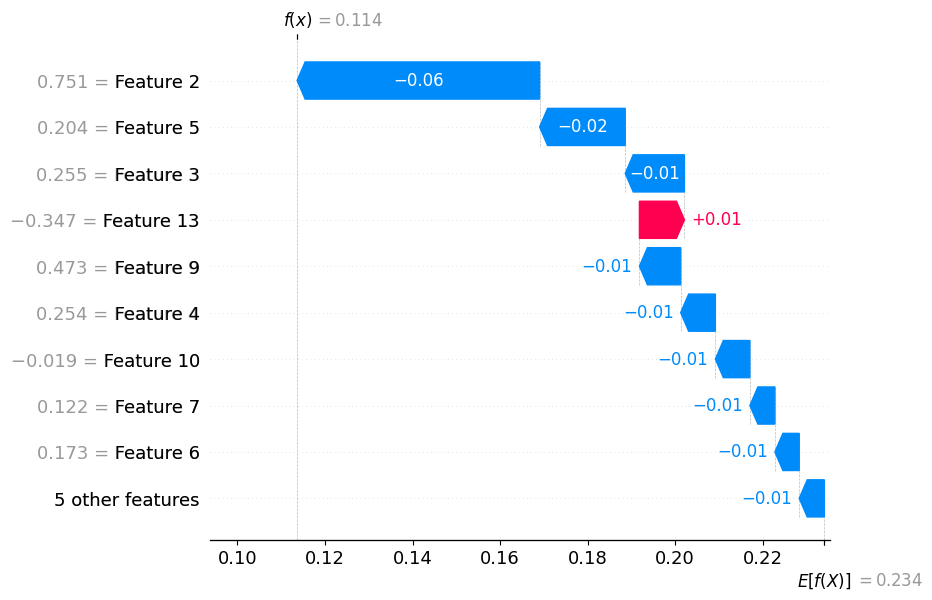

In [ ]:
from shap import Explainer, PermutationExplainer
import shap
import numpy as np

# Convert validation WOE features to numpy
X_val_np = X_val_woe.to_numpy()

# Define a callable prediction function for SHAP
def predict_fn(x_np):
    df = pd.DataFrame(x_np, columns=X_val_woe.columns)
    ds = tf.data.Dataset.from_tensor_slices(dict(df)).batch(128)
    return model.predict(ds).flatten()

# Use PermutationExplainer
explainer = shap.Explainer(predict_fn, X_val_np)
shap_values = explainer(X_val_np[:50])  # explain top 50 examples

# Plot SHAP for first customer
shap.plots.waterfall(shap_values[0])

In [ ]:
# Already trained: TFDF model
tfdf_preds_val = model.predict(df_to_tf(X_val_woe)).flatten()
tfdf_preds_train = model.predict(df_to_tf(X_train_woe)).flatten()

125/125 [==============================] - 1s 8ms/step


In [ ]:
!pip install -q xgboost
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train_woe, y_train)

xgb_preds_val = xgb.predict_proba(X_val_woe)[:, 1]
xgb_preds_train = xgb.predict_proba(X_train_woe)[:, 1]


In [ ]:
import pandas as pd

# Create stacking features
stack_train = pd.DataFrame({
    "tfdf": tfdf_preds_train,
    "xgb": xgb_preds_train  # include only if XGBoost used
})

stack_val = pd.DataFrame({
    "tfdf": tfdf_preds_val,
    "xgb": xgb_preds_val
})

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

meta = LogisticRegression()
meta.fit(stack_train, y_train)

# Predict and evaluate
meta_preds = meta.predict_proba(stack_val)[:, 1]
auc = roc_auc_score(y_val, meta_preds)
acc = accuracy_score(y_val, meta_preds > 0.5)

print(f"📈 Meta-Learner AUC: {auc:.4f}, Accuracy: {acc:.4f}")

📈 Meta-Learner AUC: 0.6960, Accuracy: 0.7827


In [ ]:
# ✅ Full working code for improved meta-learner (TFDF + XGBoost + raw WOE features)

# Step 0: Ensure required libraries are installed
!pip install -q xgboost tensorflow_decision_forests

# Step 1: Imports
import pandas as pd
import tensorflow_decision_forests as tfdf
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from xgboost import XGBClassifier

# Step 2: Load data
train_df = pd.read_csv("/content/Credit_Card_train.csv")
train_df.rename(columns={"default.payment.next.month": "target"}, inplace=True)
X = train_df.drop(columns=["target", "ID"], errors='ignore')
y = train_df["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Step 3: Apply WOE transformation
from optbinning import BinningProcess
bp = BinningProcess(variable_names=X.columns.tolist(), selection_criteria={"iv": {"min": 0.0}})
bp.fit(X_train, y_train)
X_train_woe = bp.transform(X_train)
X_val_woe = bp.transform(X_val)

# Step 4: Convert WOE data to TensorFlow-friendly format
def df_to_tf(data, labels=None):
    if labels is not None:
        return tf.data.Dataset.from_tensor_slices((dict(data), labels)).batch(128)
    else:
        return tf.data.Dataset.from_tensor_slices(dict(data)).batch(128)

# Step 5: Train TFDF model
tfdf_model = tfdf.keras.GradientBoostedTreesModel(num_trees=100, max_depth=6)
tfdf_model.fit(df_to_tf(X_train_woe, y_train))

# Step 6: Predict with TFDF
tfdf_preds_train = tfdf_model.predict(df_to_tf(X_train_woe)).flatten()
tfdf_preds_val = tfdf_model.predict(df_to_tf(X_val_woe)).flatten()

# Step 7: Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train_woe, y_train)
xgb_preds_train = xgb_model.predict_proba(X_train_woe)[:, 1]
xgb_preds_val = xgb_model.predict_proba(X_val_woe)[:, 1]

# Step 8: Create meta-learner input dataset
stack_train_full = X_train_woe.copy()
stack_train_full["tfdf_pred"] = tfdf_preds_train
stack_train_full["xgb_pred"] = xgb_preds_train

stack_val_full = X_val_woe.copy()
stack_val_full["tfdf_pred"] = tfdf_preds_val
stack_val_full["xgb_pred"] = xgb_preds_val

# Step 9: Train Logistic Regression meta-learner
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(stack_train_full, y_train)

# Step 10: Evaluate performance
meta_preds = meta_model.predict_proba(stack_val_full)[:, 1]
auc = roc_auc_score(y_val, meta_preds)
acc = accuracy_score(y_val, meta_preds > 0.5)

# Display final performance of ensemble
print(f"📊 Meta-Learner Performance:\nAUC: {auc:.4f}, Accuracy: {acc:.4f}")


Use /tmp/tmpl5duog3i as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.522926. Found 16000 examples.
Training model...
Model trained in 0:00:03.402205
Compiling model...
Model compiled.
32/32 [==============================] - 0s 3ms/step
📊 Meta-Learner Performance:
AUC: 0.6958, Accuracy: 0.7792


In [ ]:
# ⚙️ Add More Base Learners to the Ensemble: TFDF, XGBoost, RandomForest, LightGBM, Naive Bayes

# Install additional packages (LightGBM)
!pip install -q lightgbm

# Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
import pandas as pd

# Step 1: Train and collect out-of-fold predictions for each base model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# TFDF (already trained)
tfdf_preds_train = model.predict(df_to_tf(X_train_woe)).flatten()

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_oof = cross_val_predict(xgb_model, X_train_woe, y_train, cv=cv, method="predict_proba")[:, 1]
xgb_model.fit(X_train_woe, y_train)

# RandomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_oof = cross_val_predict(rf_model, X_train_woe, y_train, cv=cv, method="predict_proba")[:, 1]
rf_model.fit(X_train_woe, y_train)

# LightGBM
lgb_model = LGBMClassifier(random_state=42)
lgb_oof = cross_val_predict(lgb_model, X_train_woe, y_train, cv=cv, method="predict_proba")[:, 1]
lgb_model.fit(X_train_woe, y_train)

# Naive Bayes
nb_model = GaussianNB()
nb_oof = cross_val_predict(nb_model, X_train_woe, y_train, cv=cv, method="predict_proba")[:, 1]
nb_model.fit(X_train_woe, y_train)

# Step 2: Create meta-learner dataset (using out-of-fold predictions)
stack_train_full = pd.DataFrame({
    "tfdf": tfdf_preds_train,
    "xgb": xgb_oof,
    "rf": rf_oof,
    "lgb": lgb_oof,
    "nb": nb_oof
})

# Step 3: Train meta-learner
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(stack_train_full, y_train)

# Step 4: Prepare validation base model predictions
tfdf_preds_val = model.predict(df_to_tf(X_val_woe)).flatten()
xgb_val = xgb_model.predict_proba(X_val_woe)[:, 1]
rf_val = rf_model.predict_proba(X_val_woe)[:, 1]
lgb_val = lgb_model.predict_proba(X_val_woe)[:, 1]
nb_val = nb_model.predict_proba(X_val_woe)[:, 1]

# Step 5: Create validation input for meta-learner
stack_val_full = pd.DataFrame({
    "tfdf": tfdf_preds_val,
    "xgb": xgb_val,
    "rf": rf_val,
    "lgb": lgb_val,
    "nb": nb_val
})

# Step 6: Evaluate the stacked model
meta_preds = meta_model.predict_proba(stack_val_full)[:, 1]
auc = roc_auc_score(y_val, meta_preds)
acc = accuracy_score(y_val, meta_preds > 0.5)

auc, acc

125/125 [==============================] - 2s 11ms/step
[LightGBM] [Info] Number of positive: 2917, number of negative: 9883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 157
[LightGBM] [Info] Number of data points in the train set: 12800, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227891 -> initscore=-1.220260
[LightGBM] [Info] Start training from score -1.220260
[LightGBM] [Info] Number of positive: 2917, number of negative: 9883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 157
[LightGBM] [Info] Number of data points in the train set: 128

(np.float64(0.7547094440278156), 0.802)

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

xgb_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
grid_xgb = GridSearchCV(xgb_model, param_grid=xgb_grid, scoring='roc_auc', cv=5, verbose=3, n_jobs=-1)
grid_xgb.fit(X_train_woe, y_train)

# Best model & AUC
print("Best XGB Params:", grid_xgb.best_params_)
print("Best AUC:", grid_xgb.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best XGB Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best AUC: 0.774666383884216


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10, None],
    'max_features': ['sqrt', 'log2']
}

grid_rf = GridSearchCV(RandomForestClassifier(), rf_grid, scoring='roc_auc', cv=5)
grid_rf.fit(X_train_woe, y_train)
print("Best XGB Params:", grid_rf.best_params_)
print("Best AUC:", grid_rf.best_score_)

Best XGB Params: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}
Best AUC: 0.7743768897243506


In [ ]:
from sklearn.linear_model import LogisticRegression

meta_grid = {
    'C': [0.1, 1.0, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

grid_meta = GridSearchCV(LogisticRegression(max_iter=1000), meta_grid, scoring='roc_auc', cv=5)
grid_meta.fit(stack_train_full, y_train)
print("Best LR Params:", grid_meta.best_params_)
print("Best AUC:", grid_meta.best_score_)

Best LR Params: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Best AUC: 0.7998306262487829


In [ ]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_meta = CalibratedClassifierCV(estimator=meta_model, cv=5, method='sigmoid')
calibrated_meta.fit(stack_train_full, y_train)

CalibratedClassifierCV(cv=5, estimator=LogisticRegression(max_iter=1000))

In [ ]:
meta_calib_preds = calibrated_meta.predict_proba(stack_val_full)[:, 1]

from sklearn.metrics import roc_auc_score, accuracy_score
auc = roc_auc_score(y_val, meta_calib_preds)
acc = accuracy_score(y_val, meta_calib_preds > 0.5)

print(f"🧪 Calibrated Meta AUC: {auc:.4f}, Accuracy: {acc:.4f}")

🧪 Calibrated Meta AUC: 0.7548, Accuracy: 0.8027


In [ ]:
# 1. Imports and Data Loading
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

df = pd.read_csv("//content/Credit_Card_train.csv")

# 2. Preprocessing
categorical_cols = ["SEX", "EDUCATION", "MARRIAGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
numerical_cols = ["LIMIT_BAL", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
                  "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
target_col = "default.payment.next.month"

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

X = df[categorical_cols + numerical_cols]
y = df[target_col]
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 3. Dataset prep
def df_to_dataset(X, y, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices((dict(X), y))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = df_to_dataset(X_train, y_train)
val_ds = df_to_dataset(X_val, y_val)

# 4. TabTransformer Core
from tensorflow.keras import layers, models

def transformer_block(num_cat_features, embed_dim, num_heads, ff_dim, dropout=0.1):
    inputs = tf.keras.Input(shape=(num_cat_features, embed_dim))  # 3D input
    x = layers.LayerNormalization()(inputs)
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization()(x)
    ffn = layers.Dense(ff_dim, activation='relu')(x)
    ffn = layers.Dense(embed_dim)(ffn)
    x = layers.Add()([x, ffn])
    return tf.keras.Model(inputs, x)

# 5. Build Full TabTransformer
def build_tabtransformer(cat_vocab_sizes, num_num_features, embed_dim=32):
    # Inputs
    cat_inputs = [layers.Input(shape=(1,), name=f"cat_{i}") for i in range(len(cat_vocab_sizes))]
    num_input = layers.Input(shape=(num_num_features,), name="numerical")

    # Embeddings + Transformer
    embeddings = [layers.Embedding(input_dim=vocab, output_dim=embed_dim)(x) for x, vocab in zip(cat_inputs, cat_vocab_sizes)]
    x = layers.Concatenate(axis=1)(embeddings)
    x = transformer_block(num_cat_features=len(cat_vocab_sizes), embed_dim=embed_dim, num_heads=4, ff_dim=64)(x)
    x = layers.Flatten()(x)

    # Combine with numerical
    x = layers.Concatenate()([x, num_input])
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    output = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=cat_inputs + [num_input], outputs=output)
    return model

# 6. Prepare Inputs for Keras
def make_model_input(X_df):
    model_input = [X_df[col].values for col in categorical_cols]
    model_input.append(X_df[numerical_cols].values)
    return model_input

cat_vocab_sizes = [df[col].nunique() for col in categorical_cols]
model = build_tabtransformer(cat_vocab_sizes, len(numerical_cols))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

# 7. Train
history = model.fit(make_model_input(X_train), y_train.values,
                    validation_data=(make_model_input(X_val), y_val.values),
                    epochs=10, batch_size=64)

# 8. Evaluate
y_pred_proba = model.predict(make_model_input(X_val)).flatten()
auc = roc_auc_score(y_val, y_pred_proba)
acc = accuracy_score(y_val, y_pred_proba > 0.5)

print(f"🧠 TabTransformer AUC: {auc:.4f} | Accuracy: {acc:.4f}")


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.7925 - auc: 0.7022 - loss: 0.4905 - val_accuracy: 0.8112 - val_auc: 0.7513 - val_loss: 0.4532
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.8176 - auc: 0.7580 - loss: 0.4444 - val_accuracy: 0.8062 - val_auc: 0.7605 - val_loss: 0.4522
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8241 - auc: 0.7693 - loss: 0.4372 - val_accuracy: 0.8092 - val_auc: 0.7582 - val_loss: 0.4518
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8171 - auc: 0.7603 - loss: 0.4445 - val_accuracy: 0.8100 - val_auc: 0.7620 - val_loss: 0.4531
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8168 - auc: 0.7743 - loss: 0.4392 - val_accuracy: 0.8095 - val_auc: 0.7572 - val_loss: 0.4523
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8192 - auc: 0.7733 - loss: 0.4373 - val_accuracy: 0.8092 - val_auc: 0.7569 - val_loss: 0.4540
Epoch 7/10
250/250 ━━━━━━━━━━━━━

In [ ]:
!pip install optuna --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 11.5 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras import layers, models, Input

def transformer_block(num_cat_features, embed_dim, num_heads, ff_dim, dropout):
    inputs = Input(shape=(num_cat_features, embed_dim))

    x = layers.LayerNormalization()(inputs)
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    x = layers.Add()([x, attn_output])

    x = layers.LayerNormalization()(x)
    ffn = layers.Dense(ff_dim, activation='relu')(x)
    ffn = layers.Dropout(dropout)(ffn)
    ffn = layers.Dense(embed_dim)(ffn)
    x = layers.Add()([x, ffn])

    return models.Model(inputs, x, name="transformer_block")

def build_tabtransformer(cat_vocab_sizes, num_num_features,
                         embed_dim=32, num_heads=4, ff_dim=64,
                         dropout=0.1, hidden_layers=[64, 32]):

    # Categorical Embeddings
    cat_inputs = [Input(shape=(1,), name=f"cat_{i}") for i in range(len(cat_vocab_sizes))]
    embeddings = [layers.Embedding(input_dim=vocab, output_dim=embed_dim)(x)
                  for x, vocab in zip(cat_inputs, cat_vocab_sizes)]

    x = layers.Concatenate(axis=1)(embeddings)

    # Transformer block
    x = transformer_block(num_cat_features=len(cat_vocab_sizes),
                          embed_dim=embed_dim,
                          num_heads=num_heads,
                          ff_dim=ff_dim,
                          dropout=dropout)(x)

    x = layers.Flatten()(x)

    # Numerical input
    num_input = Input(shape=(num_num_features,), name="numerical")

    # Combine numerical and categorical
    x = layers.Concatenate()([x, num_input])

    # Dense layers
    for units in hidden_layers:
        x = layers.Dense(units, activation='relu')(x)

    output = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=cat_inputs + [num_input], outputs=output)
    return model


In [ ]:
import optuna
from sklearn.metrics import roc_auc_score
import tensorflow as tf

def objective(trial):
    embed_dim = trial.suggest_categorical("embed_dim", [16, 32, 64])
    num_heads = trial.suggest_categorical("num_heads", [2, 4, 8])
    ff_dim = trial.suggest_categorical("ff_dim", [32, 64, 128])
    dropout = trial.suggest_float("dropout", 0.1, 0.3)

    # Hidden layers as a list
    n_layers = trial.suggest_int("n_layers", 1, 3)
    hidden_layers = []
    for i in range(n_layers):
        hidden_layers.append(trial.suggest_categorical(f"hidden_units_{i}", [32, 64, 128]))

    # Build model
    model = build_tabtransformer(
        cat_vocab_sizes=cat_vocab_sizes,
        num_num_features=len(numerical_cols),
        embed_dim=embed_dim,
        num_heads=num_heads,
        ff_dim=ff_dim,
        dropout=dropout,
        hidden_layers=hidden_layers
    )

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC()])

    # Train
    model.fit(
        make_model_input(X_train), y_train.values,
        validation_data=(make_model_input(X_val), y_val.values),
        epochs=5,
        batch_size=64,
        verbose=0
    )

    # Evaluate AUC
    y_pred_proba = model.predict(make_model_input(X_val)).flatten()
    auc = roc_auc_score(y_val, y_pred_proba)
    return auc

In [ ]:
import optuna

optuna.logging.set_verbosity(optuna.logging.INFO)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2025-06-29 18:07:09,860] A new study created in memory with name: no-name-d12446fc-b035-4d1d-85e2-c26e931ffac5


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-06-29 18:08:01,775] Trial 0 finished with value: 0.7646536749500046 and parameters: {'embed_dim': 64, 'num_heads': 2, 'ff_dim': 32, 'dropout': 0.1721084116962379, 'n_layers': 1, 'hidden_units_0': 128}. Best is trial 0 with value: 0.7646536749500046.


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


[I 2025-06-29 18:09:02,071] Trial 1 finished with value: 0.7645888726024908 and parameters: {'embed_dim': 32, 'num_heads': 8, 'ff_dim': 64, 'dropout': 0.17815921548467348, 'n_layers': 3, 'hidden_units_0': 64, 'hidden_units_1': 32, 'hidden_units_2': 32}. Best is trial 0 with value: 0.7646536749500046.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


[I 2025-06-29 18:09:55,741] Trial 2 finished with value: 0.7643417359785474 and parameters: {'embed_dim': 32, 'num_heads': 4, 'ff_dim': 64, 'dropout': 0.15820082466531846, 'n_layers': 2, 'hidden_units_0': 64, 'hidden_units_1': 128}. Best is trial 0 with value: 0.7646536749500046.


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


[I 2025-06-29 18:10:44,167] Trial 3 finished with value: 0.7640635297359331 and parameters: {'embed_dim': 16, 'num_heads': 8, 'ff_dim': 32, 'dropout': 0.16196048382123363, 'n_layers': 3, 'hidden_units_0': 32, 'hidden_units_1': 32, 'hidden_units_2': 32}. Best is trial 0 with value: 0.7646536749500046.


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


[I 2025-06-29 18:11:25,340] Trial 4 finished with value: 0.7650629062130716 and parameters: {'embed_dim': 32, 'num_heads': 2, 'ff_dim': 32, 'dropout': 0.21706661341598463, 'n_layers': 2, 'hidden_units_0': 32, 'hidden_units_1': 128}. Best is trial 4 with value: 0.7650629062130716.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-06-29 18:12:12,021] Trial 5 finished with value: 0.7610194172688846 and parameters: {'embed_dim': 32, 'num_heads': 2, 'ff_dim': 128, 'dropout': 0.26991460001618506, 'n_layers': 2, 'hidden_units_0': 128, 'hidden_units_1': 32}. Best is trial 4 with value: 0.7650629062130716.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-06-29 18:12:59,041] Trial 6 finished with value: 0.7570320311789838 and parameters: {'embed_dim': 64, 'num_heads': 2, 'ff_dim': 64, 'dropout': 0.21992477808078265, 'n_layers': 2, 'hidden_units_0': 32, 'hidden_units_1': 64}. Best is trial 4 with value: 0.7650629062130716.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2025-06-29 18:13:51,489] Trial 7 finished with value: 0.7614167533065176 and parameters: {'embed_dim': 32, 'num_heads': 4, 'ff_dim': 64, 'dropout': 0.20275193977779415, 'n_layers': 3, 'hidden_units_0': 64, 'hidden_units_1': 128, 'hidden_units_2': 32}. Best is trial 4 with value: 0.7650629062130716.


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


[I 2025-06-29 18:15:27,177] Trial 8 finished with value: 0.7631328615012272 and parameters: {'embed_dim': 64, 'num_heads': 4, 'ff_dim': 32, 'dropout': 0.2803799806574371, 'n_layers': 2, 'hidden_units_0': 128, 'hidden_units_1': 64}. Best is trial 4 with value: 0.7650629062130716.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


[I 2025-06-29 18:16:17,922] Trial 9 finished with value: 0.7625157301040815 and parameters: {'embed_dim': 32, 'num_heads': 4, 'ff_dim': 64, 'dropout': 0.1642198607033285, 'n_layers': 2, 'hidden_units_0': 128, 'hidden_units_1': 64}. Best is trial 4 with value: 0.7650629062130716.


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


[I 2025-06-29 18:16:54,187] Trial 10 finished with value: 0.7670472783724207 and parameters: {'embed_dim': 16, 'num_heads': 2, 'ff_dim': 128, 'dropout': 0.11182571368913467, 'n_layers': 1, 'hidden_units_0': 32}. Best is trial 10 with value: 0.7670472783724207.


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


[I 2025-06-29 18:17:35,638] Trial 11 finished with value: 0.7648242915416781 and parameters: {'embed_dim': 16, 'num_heads': 2, 'ff_dim': 128, 'dropout': 0.11099794122326954, 'n_layers': 1, 'hidden_units_0': 32}. Best is trial 10 with value: 0.7670472783724207.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-06-29 18:18:15,063] Trial 12 finished with value: 0.7611802691232615 and parameters: {'embed_dim': 16, 'num_heads': 2, 'ff_dim': 128, 'dropout': 0.10848363200048199, 'n_layers': 1, 'hidden_units_0': 32}. Best is trial 10 with value: 0.7670472783724207.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2025-06-29 18:18:51,026] Trial 13 finished with value: 0.767836624227343 and parameters: {'embed_dim': 16, 'num_heads': 2, 'ff_dim': 128, 'dropout': 0.24603435474269775, 'n_layers': 1, 'hidden_units_0': 32}. Best is trial 13 with value: 0.767836624227343.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2025-06-29 18:19:24,785] Trial 14 finished with value: 0.7669720011248977 and parameters: {'embed_dim': 16, 'num_heads': 2, 'ff_dim': 128, 'dropout': 0.25035367861284874, 'n_layers': 1, 'hidden_units_0': 32}. Best is trial 13 with value: 0.767836624227343.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-06-29 18:19:56,589] Trial 15 finished with value: 0.7677556656781203 and parameters: {'embed_dim': 16, 'num_heads': 2, 'ff_dim': 128, 'dropout': 0.29926851140842625, 'n_layers': 1, 'hidden_units_0': 32}. Best is trial 13 with value: 0.767836624227343.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-06-29 18:20:52,534] Trial 16 finished with value: 0.7696960077492955 and parameters: {'embed_dim': 16, 'num_heads': 8, 'ff_dim': 128, 'dropout': 0.29798201182635586, 'n_layers': 1, 'hidden_units_0': 32}. Best is trial 16 with value: 0.7696960077492955.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


[I 2025-06-29 18:21:41,392] Trial 17 finished with value: 0.7630595372011635 and parameters: {'embed_dim': 16, 'num_heads': 8, 'ff_dim': 128, 'dropout': 0.2495484068517967, 'n_layers': 1, 'hidden_units_0': 32}. Best is trial 16 with value: 0.7696960077492955.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


[I 2025-06-29 18:22:33,950] Trial 18 finished with value: 0.7644331694277793 and parameters: {'embed_dim': 16, 'num_heads': 8, 'ff_dim': 128, 'dropout': 0.24531331827192468, 'n_layers': 1, 'hidden_units_0': 32}. Best is trial 16 with value: 0.7696960077492955.


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


[I 2025-06-29 18:23:29,505] Trial 19 finished with value: 0.7624202132192528 and parameters: {'embed_dim': 16, 'num_heads': 8, 'ff_dim': 128, 'dropout': 0.29823330851755536, 'n_layers': 1, 'hidden_units_0': 64}. Best is trial 16 with value: 0.7696960077492955.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

def transformer_encoder(inputs, embed_dim, num_heads, ff_dim, dropout):
    x = layers.LayerNormalization()(inputs)
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    x = layers.Add()([x, attn_output])

    x = layers.LayerNormalization()(x)
    ffn = layers.Dense(ff_dim, activation='relu')(x)
    ffn = layers.Dropout(dropout)(ffn)
    ffn = layers.Dense(embed_dim)(ffn)
    x = layers.Add()([x, ffn])
    return x


In [ ]:
def build_ft_transformer(cat_vocab_sizes, num_num_features,
                         embed_dim=32, num_heads=4, ff_dim=64,
                         dropout=0.1, num_blocks=3, mlp_units=[64, 32]):

    # Categorical Embedding Tokens
    cat_inputs = [Input(shape=(1,), name=f"cat_{i}") for i in range(len(cat_vocab_sizes))]
    cat_embeds = [layers.Embedding(input_dim=sz, output_dim=embed_dim)(inp) for inp, sz in zip(cat_inputs, cat_vocab_sizes)]
    cat_token = layers.Concatenate(axis=1)(cat_embeds)

    # Numerical Projection Tokens
    # Numerical Projection Tokens
    num_input = Input(shape=(num_num_features,), name="numerical")
    num_dense = layers.Dense(embed_dim)(num_input)
    num_token = layers.Reshape((1, embed_dim))(num_dense)  # ✅ FIXED
   # shape: (batch, 1, embed_dim)

    # Combine all tokens
    all_tokens = layers.Concatenate(axis=1)([num_token, cat_token])  # shape: (batch, N+1, embed_dim)

    # Transformer Blocks
    x = all_tokens
    for _ in range(num_blocks):
        x = transformer_encoder(x, embed_dim, num_heads, ff_dim, dropout)

    x = layers.LayerNormalization()(x)
    x = layers.Flatten()(x)

    # MLP head
    for units in mlp_units:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(dropout)(x)

    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    return model


In [ ]:
model = build_ft_transformer(
    cat_vocab_sizes=cat_vocab_sizes,
    num_num_features=len(numerical_cols),
    embed_dim=32,
    num_heads=4,
    ff_dim=64,
    dropout=0.1,
    num_blocks=2,
    mlp_units=[64, 32]
)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
model.fit(make_model_input(X_train), y_train, validation_data=(make_model_input(X_val), y_val), epochs=10, batch_size=64, verbose = 1)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 58ms/step - auc_23: 0.7063 - loss: 0.5005 - val_auc_23: 0.7588 - val_loss: 0.4572
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - auc_23: 0.7444 - loss: 0.4565 - val_auc_23: 0.7622 - val_loss: 0.4513
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - auc_23: 0.7518 - loss: 0.4487 - val_auc_23: 0.7630 - val_loss: 0.4486
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - auc_23: 0.7634 - loss: 0.4432 - val_auc_23: 0.7610 - val_loss: 0.4533
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - auc_23: 0.7596 - loss: 0.4507 - val_auc_23: 0.7700 - val_loss: 0.4457
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - auc_23: 0.7597 - loss: 0.4483 - val_auc_23: 0.7687 - val_loss: 0.4502
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - auc_23: 0.7732 - loss: 0.4388 - val_auc_23: 0.7697 - val_loss: 0.4450
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - auc_23: 0.7725 - loss: 0.4422 - val_auc_23: 0.7702 - val_loss:

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping

# Transformer block

def transformer_encoder(inputs, embed_dim, num_heads, ff_dim, dropout):
    x = layers.LayerNormalization()(inputs)
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    x = layers.Add()([x, attn_output])

    x = layers.LayerNormalization()(x)
    ffn = layers.Dense(ff_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    ffn = layers.Dropout(dropout)(ffn)
    ffn = layers.Dense(embed_dim, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(ffn)
    x = layers.Add()([x, ffn])
    return x

# FT-Transformer model

def build_ft_transformer(cat_vocab_sizes, num_num_features,
                         embed_dim=32, num_heads=4, ff_dim=64,
                         dropout=0.1, num_blocks=3, mlp_units=[64, 32]):

    cat_inputs = [Input(shape=(1,), name=f"cat_{i}") for i in range(len(cat_vocab_sizes))]
    cat_embeds = [layers.Embedding(input_dim=sz, output_dim=embed_dim)(inp) for inp, sz in zip(cat_inputs, cat_vocab_sizes)]
    cat_token = layers.Concatenate(axis=1)(cat_embeds)

    num_input = Input(shape=(num_num_features,), name="numerical")
    num_dense = layers.Dense(embed_dim)(num_input)
    num_token = layers.Reshape((1, embed_dim))(num_dense)

    all_tokens = layers.Concatenate(axis=1)([num_token, cat_token])

    x = all_tokens
    for _ in range(num_blocks):
        x = transformer_encoder(x, embed_dim, num_heads, ff_dim, dropout)

    x = layers.LayerNormalization()(x)
    x = layers.Flatten()(x)

    for units in mlp_units:
        x = layers.Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
        x = layers.Dropout(dropout)(x)

    output = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    return model

# Assuming make_model_input, X_train, X_val, y_train, y_val, categorical_cols, numerical_cols, cat_vocab_sizes are defined
model = build_ft_transformer(
    cat_vocab_sizes=cat_vocab_sizes,
    num_num_features=len(numerical_cols),
    embed_dim=32,
    num_heads=4,
    ff_dim=64,
    dropout=0.1,
    num_blocks=2,
    mlp_units=[64, 32]
)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])

early_stop = EarlyStopping(monitor='val_auc', mode='max', patience=3, restore_best_weights=True)

history = model.fit(
    make_model_input(X_train), y_train,
    validation_data=(make_model_input(X_val), y_val),
    epochs=20,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)  # This will show epoch logs

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - auc: 0.7079 - loss: 0.5147 - val_auc: 0.7627 - val_loss: 0.4795
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - auc: 0.7570 - loss: 0.4835 - val_auc: 0.7612 - val_loss: 0.4794
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - auc: 0.7511 - loss: 0.4824 - val_auc: 0.7583 - val_loss: 0.4783
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - auc: 0.7575 - loss: 0.4797 - val_auc: 0.7613 - val_loss: 0.4780


[I 2025-06-29 18:41:52,592] A new study created in memory with name: no-name-036e44b3-9652-435f-9298-3c330738bb6f


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - auc: 0.6925 - loss: 0.5265 - val_auc: 0.7634 - val_loss: 0.4818
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - auc: 0.7519 - loss: 0.4786 - val_auc: 0.7644 - val_loss: 0.4747
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - auc: 0.7445 - loss: 0.4779 - val_auc: 0.7632 - val_loss: 0.4757
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - auc: 0.7520 - loss: 0.4741 - val_auc: 0.7675 - val_loss: 0.4712
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - auc: 0.7668 - loss: 0.4661 - val_auc: 0.7614 - val_loss: 0.4730
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - auc: 0.7637 - loss: 0.4697 - val_auc: 0.7683 - val_loss: 0.4656
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - auc: 0.7769 - loss: 0.4530 - val_auc: 0.7681 - val_loss: 0.4660
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - auc: 0.7642 - loss: 0.4610 - val_auc: 0.7691 - val_loss: 0.4625
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 12

[I 2025-06-29 18:44:51,489] Trial 0 finished with value: 0.7636253593423324 and parameters: {'embed_dim': 16, 'num_heads': 2, 'ff_dim': 128, 'dropout': 0.12062735902994676, 'num_blocks': 3}. Best is trial 0 with value: 0.7636253593423324.


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - auc: 0.6933 - loss: 0.5174 - val_auc: 0.7541 - val_loss: 0.4818
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - auc: 0.7469 - loss: 0.4861 - val_auc: 0.7651 - val_loss: 0.4776
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - auc: 0.7467 - loss: 0.4736 - val_auc: 0.7591 - val_loss: 0.4759
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - auc: 0.7694 - loss: 0.4636 - val_auc: 0.7626 - val_loss: 0.4759
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7562 - loss: 0.4714 - val_auc: 0.7693 - val_loss: 0.4692
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - auc: 0.7578 - loss: 0.4644 - val_auc: 0.7633 - val_loss: 0.4716
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - auc: 0.7641 - loss: 0.4706 - val_auc: 0.7658 - val_loss: 0.4736
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - auc: 0.7768 - loss: 0.4609 - val_auc: 0.7636 - val_loss: 0.4697
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36

[I 2025-06-29 18:46:52,230] Trial 1 finished with value: 0.7677936593832378 and parameters: {'embed_dim': 16, 'num_heads': 2, 'ff_dim': 64, 'dropout': 0.1440616976499804, 'num_blocks': 3}. Best is trial 1 with value: 0.7677936593832378.


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - auc: 0.6822 - loss: 0.5452 - val_auc: 0.7573 - val_loss: 0.4832
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - auc: 0.7539 - loss: 0.4818 - val_auc: 0.7543 - val_loss: 0.4774
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - auc: 0.7426 - loss: 0.4806 - val_auc: 0.7621 - val_loss: 0.4727
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - auc: 0.7488 - loss: 0.4665 - val_auc: 0.7620 - val_loss: 0.4756
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - auc: 0.7615 - loss: 0.4690 - val_auc: 0.7654 - val_loss: 0.4658
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - auc: 0.7635 - loss: 0.4678 - val_auc: 0.7698 - val_loss: 0.4639
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - auc: 0.7639 - loss: 0.4580 - val_auc: 0.7665 - val_loss: 0.4642
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - auc: 0.7674 - loss: 0.4570 - val_auc: 0.7648 - val_loss: 0.4658
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-06-29 18:49:37,664] Trial 2 finished with value: 0.7691294754454141 and parameters: {'embed_dim': 32, 'num_heads': 8, 'ff_dim': 128, 'dropout': 0.17143801451600035, 'num_blocks': 1}. Best is trial 2 with value: 0.7691294754454141.


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 49ms/step - auc: 0.6579 - loss: 0.5523 - val_auc: 0.7615 - val_loss: 0.4866
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - auc: 0.7165 - loss: 0.5045 - val_auc: 0.7578 - val_loss: 0.4833
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - auc: 0.7479 - loss: 0.4801 - val_auc: 0.7607 - val_loss: 0.4773
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - auc: 0.7552 - loss: 0.4731 - val_auc: 0.7620 - val_loss: 0.4774
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - auc: 0.7509 - loss: 0.4760 - val_auc: 0.7641 - val_loss: 0.4795
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - auc: 0.7608 - loss: 0.4729 - val_auc: 0.7659 - val_loss: 0.4703
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - auc: 0.7561 - loss: 0.4743 - val_auc: 0.7653 - val_loss: 0.4697
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - auc: 0.7679 - loss: 0.4581 - val_auc: 0.7635 - val_loss: 0.4704
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-06-29 18:52:15,647] Trial 3 finished with value: 0.7680294334037815 and parameters: {'embed_dim': 16, 'num_heads': 4, 'ff_dim': 64, 'dropout': 0.2934216172325368, 'num_blocks': 3}. Best is trial 2 with value: 0.7691294754454141.


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 52s 153ms/step - auc: 0.6860 - loss: 0.5565 - val_auc: 0.7601 - val_loss: 0.4933
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - auc: 0.7349 - loss: 0.5095 - val_auc: 0.7602 - val_loss: 0.4945
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 150ms/step - auc: 0.7330 - loss: 0.4973 - val_auc: 0.7701 - val_loss: 0.4954
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 152ms/step - auc: 0.7511 - loss: 0.4920 - val_auc: 0.7658 - val_loss: 0.4880
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 150ms/step - auc: 0.7508 - loss: 0.4859 - val_auc: 0.7667 - val_loss: 0.4875
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 152ms/step - auc: 0.7669 - loss: 0.4678 - val_auc: 0.7664 - val_loss: 0.4799
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 159ms/step - auc: 0.7521 - loss: 0.4743 - val_auc: 0.7681 - val_loss: 0.4738
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 160ms/step - auc: 0.7623 - loss: 0.4701 - val_auc: 0.7644 - val_loss: 0.4789
Epoch 9/10
250/250 ━━━━━━━━━━━━━

[I 2025-06-29 18:59:16,572] Trial 4 finished with value: 0.7580562633510591 and parameters: {'embed_dim': 64, 'num_heads': 8, 'ff_dim': 64, 'dropout': 0.2932126060694542, 'num_blocks': 2}. Best is trial 2 with value: 0.7691294754454141.


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step - auc: 0.7112 - loss: 0.5253 - val_auc: 0.7575 - val_loss: 0.4855
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - auc: 0.7518 - loss: 0.4842 - val_auc: 0.7657 - val_loss: 0.4844
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - auc: 0.7603 - loss: 0.4765 - val_auc: 0.7663 - val_loss: 0.4758
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - auc: 0.7546 - loss: 0.4739 - val_auc: 0.7699 - val_loss: 0.4807
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - auc: 0.7626 - loss: 0.4619 - val_auc: 0.7672 - val_loss: 0.4705
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - auc: 0.7621 - loss: 0.4688 - val_auc: 0.7660 - val_loss: 0.4665
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - auc: 0.7723 - loss: 0.4565 - val_auc: 0.7631 - val_loss: 0.4659
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - auc: 0.7772 - loss: 0.4520 - val_auc: 0.7676 - val_loss: 0.4667
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-06-29 19:02:36,175] Trial 5 finished with value: 0.7541432668052905 and parameters: {'embed_dim': 64, 'num_heads': 4, 'ff_dim': 256, 'dropout': 0.14224122476784645, 'num_blocks': 1}. Best is trial 2 with value: 0.7691294754454141.


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 145ms/step - auc: 0.7011 - loss: 0.5646 - val_auc: 0.7630 - val_loss: 0.5169
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - auc: 0.7304 - loss: 0.5249 - val_auc: 0.7593 - val_loss: 0.5120
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 143ms/step - auc: 0.7425 - loss: 0.5135 - val_auc: 0.7651 - val_loss: 0.5059
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 146ms/step - auc: 0.7555 - loss: 0.5026 - val_auc: 0.7665 - val_loss: 0.4936
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 142ms/step - auc: 0.7505 - loss: 0.5010 - val_auc: 0.7731 - val_loss: 0.5010
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 138ms/step - auc: 0.7618 - loss: 0.4864 - val_auc: 0.7711 - val_loss: 0.4854
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 141ms/step - auc: 0.7652 - loss: 0.4795 - val_auc: 0.7650 - val_loss: 0.4802
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 150ms/step - auc: 0.7629 - loss: 0.4751 - val_auc: 0.7634 - val_loss: 0.4760
Epoch 9/10
250/250 ━━━━━━━━━━━━━

[I 2025-06-29 19:09:17,005] Trial 6 finished with value: 0.7669712909621852 and parameters: {'embed_dim': 64, 'num_heads': 4, 'ff_dim': 128, 'dropout': 0.20621914016990645, 'num_blocks': 3}. Best is trial 2 with value: 0.7691294754454141.


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 88ms/step - auc: 0.6865 - loss: 0.5437 - val_auc: 0.7447 - val_loss: 0.5038
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - auc: 0.7377 - loss: 0.5101 - val_auc: 0.7628 - val_loss: 0.4992
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - auc: 0.7303 - loss: 0.5008 - val_auc: 0.7637 - val_loss: 0.4905
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - auc: 0.7453 - loss: 0.4907 - val_auc: 0.7650 - val_loss: 0.4825
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - auc: 0.7515 - loss: 0.4826 - val_auc: 0.7661 - val_loss: 0.4790
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - auc: 0.7568 - loss: 0.4867 - val_auc: 0.7663 - val_loss: 0.4836
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - auc: 0.7589 - loss: 0.4760 - val_auc: 0.7656 - val_loss: 0.4788
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - auc: 0.7643 - loss: 0.4689 - val_auc: 0.7675 - val_loss: 0.4699
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-06-29 19:15:46,703] Trial 7 finished with value: 0.7654936198981911 and parameters: {'embed_dim': 64, 'num_heads': 4, 'ff_dim': 64, 'dropout': 0.24548753120362624, 'num_blocks': 2}. Best is trial 2 with value: 0.7691294754454141.


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - auc: 0.6958 - loss: 0.5124 - val_auc: 0.7596 - val_loss: 0.4683
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - auc: 0.7548 - loss: 0.4665 - val_auc: 0.7634 - val_loss: 0.4675
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - auc: 0.7599 - loss: 0.4623 - val_auc: 0.7600 - val_loss: 0.4682
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - auc: 0.7618 - loss: 0.4602 - val_auc: 0.7684 - val_loss: 0.4618
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - auc: 0.7623 - loss: 0.4577 - val_auc: 0.7647 - val_loss: 0.4621
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - auc: 0.7659 - loss: 0.4529 - val_auc: 0.7674 - val_loss: 0.4631
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - auc: 0.7717 - loss: 0.4486 - val_auc: 0.7695 - val_loss: 0.4626
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - auc: 0.7594 - loss: 0.4594 - val_auc: 0.7679 - val_loss: 0.4604
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11

[I 2025-06-29 19:17:40,909] Trial 8 finished with value: 0.7700445201004454 and parameters: {'embed_dim': 16, 'num_heads': 8, 'ff_dim': 128, 'dropout': 0.12256747246332544, 'num_blocks': 1}. Best is trial 8 with value: 0.7700445201004454.


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - auc: 0.6841 - loss: 0.5344 - val_auc: 0.7575 - val_loss: 0.4760
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - auc: 0.7398 - loss: 0.4828 - val_auc: 0.7626 - val_loss: 0.4726
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - auc: 0.7536 - loss: 0.4777 - val_auc: 0.7660 - val_loss: 0.4701
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - auc: 0.7552 - loss: 0.4754 - val_auc: 0.7653 - val_loss: 0.4686
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - auc: 0.7575 - loss: 0.4700 - val_auc: 0.7660 - val_loss: 0.4746
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - auc: 0.7618 - loss: 0.4704 - val_auc: 0.7685 - val_loss: 0.4647
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - auc: 0.7548 - loss: 0.4710 - val_auc: 0.7641 - val_loss: 0.4676
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - auc: 0.7611 - loss: 0.4642 - val_auc: 0.7699 - val_loss: 0.4635
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-06-29 19:20:51,985] Trial 9 finished with value: 0.7716574771611672 and parameters: {'embed_dim': 16, 'num_heads': 8, 'ff_dim': 256, 'dropout': 0.28532038230247647, 'num_blocks': 2}. Best is trial 9 with value: 0.7716574771611672.


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 72ms/step - auc: 0.6921 - loss: 0.5338 - val_auc: 0.7580 - val_loss: 0.4760
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - auc: 0.7313 - loss: 0.4961 - val_auc: 0.7638 - val_loss: 0.4732
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - auc: 0.7368 - loss: 0.4860 - val_auc: 0.7639 - val_loss: 0.4706
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - auc: 0.7508 - loss: 0.4698 - val_auc: 0.7656 - val_loss: 0.4681
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - auc: 0.7614 - loss: 0.4659 - val_auc: 0.7636 - val_loss: 0.4741
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - auc: 0.7567 - loss: 0.4688 - val_auc: 0.7669 - val_loss: 0.4685
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - auc: 0.7589 - loss: 0.4695 - val_auc: 0.7695 - val_loss: 0.4631
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - auc: 0.7679 - loss: 0.4584 - val_auc: 0.7673 - val_loss: 0.4681
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 

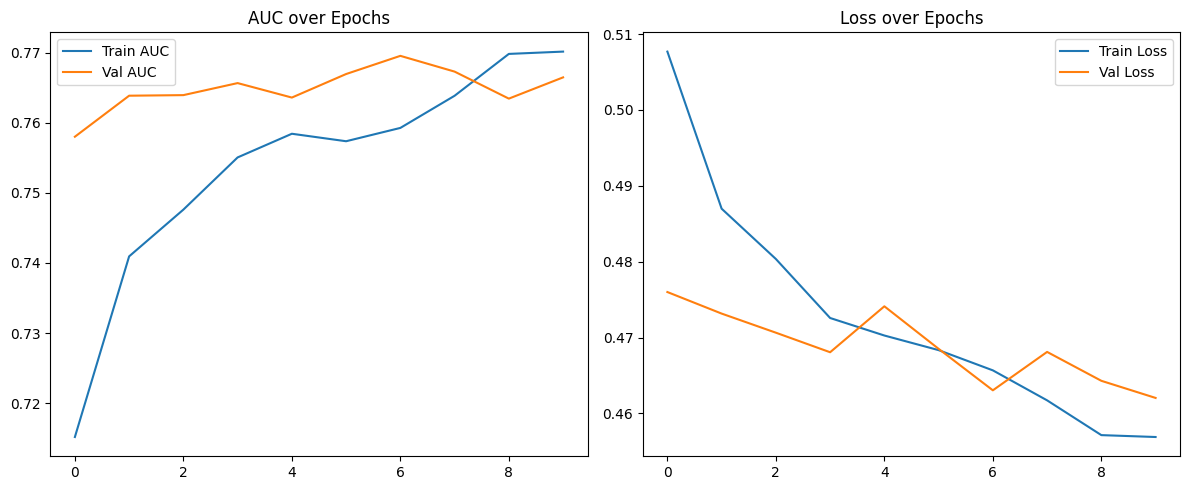

ValueError: max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 8001!

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import shap
import optuna
from sklearn.metrics import roc_auc_score

# Transformer block

def transformer_encoder(inputs, embed_dim, num_heads, ff_dim, dropout):
    x = layers.LayerNormalization()(inputs)
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    x = layers.Add()([x, attn_output])

    x = layers.LayerNormalization()(x)
    ffn = layers.Dense(ff_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    ffn = layers.Dropout(dropout)(ffn)
    ffn = layers.Dense(embed_dim, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(ffn)
    x = layers.Add()([x, ffn])
    return x

# FT-Transformer model

def build_ft_transformer(cat_vocab_sizes, num_num_features,
                         embed_dim=32, num_heads=4, ff_dim=64,
                         dropout=0.1, num_blocks=3, mlp_units=[64, 32]):

    cat_inputs = [Input(shape=(1,), name=f"cat_{i}") for i in range(len(cat_vocab_sizes))]
    cat_embeds = [layers.Embedding(input_dim=sz, output_dim=embed_dim)(inp) for inp, sz in zip(cat_inputs, cat_vocab_sizes)]
    cat_token = layers.Concatenate(axis=1)(cat_embeds)

    num_input = Input(shape=(num_num_features,), name="numerical")
    num_dense = layers.Dense(embed_dim)(num_input)
    num_token = layers.Reshape((1, embed_dim))(num_dense)

    all_tokens = layers.Concatenate(axis=1)([num_token, cat_token])

    x = all_tokens
    for _ in range(num_blocks):
        x = transformer_encoder(x, embed_dim, num_heads, ff_dim, dropout)

    x = layers.LayerNormalization()(x)
    x = layers.Flatten()(x)

    for units in mlp_units:
        x = layers.Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
        x = layers.Dropout(dropout)(x)

    output = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    return model

# Optuna objective function

def objective(trial):
    embed_dim = trial.suggest_categorical("embed_dim", [16, 32, 64])
    num_heads = trial.suggest_categorical("num_heads", [2, 4, 8])
    ff_dim = trial.suggest_categorical("ff_dim", [64, 128, 256])
    dropout = trial.suggest_float("dropout", 0.1, 0.3)
    num_blocks = trial.suggest_int("num_blocks", 1, 3)

    model = build_ft_transformer(
        cat_vocab_sizes=cat_vocab_sizes,
        num_num_features=len(numerical_cols),
        embed_dim=embed_dim,
        num_heads=num_heads,
        ff_dim=ff_dim,
        dropout=dropout,
        num_blocks=num_blocks,
        mlp_units=[64, 32]
    )

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
    model.fit(
        make_model_input(X_train), y_train,
        validation_data=(make_model_input(X_val), y_val),
        epochs=10, batch_size=64, verbose=1
    )

    val_preds = model.predict(make_model_input(X_val)).ravel()
    return roc_auc_score(y_val, val_preds)

# Run Optuna
optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Train with best params
best_params = study.best_params
model = build_ft_transformer(
    cat_vocab_sizes=cat_vocab_sizes,
    num_num_features=len(numerical_cols),
    embed_dim=best_params['embed_dim'],
    num_heads=best_params['num_heads'],
    ff_dim=best_params['ff_dim'],
    dropout=best_params['dropout'],
    num_blocks=best_params['num_blocks'],
    mlp_units=[64, 32]
)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
early_stop = EarlyStopping(monitor='val_auc', mode='max', patience=3, restore_best_weights=True)

history = model.fit(
    make_model_input(X_train), y_train,
    validation_data=(make_model_input(X_val), y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Plot AUC and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

# Predict class labels using threshold 0.5
y_pred_probs = model.predict(make_model_input(X_val)).ravel()
y_pred_labels = (y_pred_probs >= 0.5).astype(int)

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_val, y_pred_labels).ravel()

# Print detailed results
print(f"\n📊 Confusion Matrix Metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

# Optional: Print derived metrics
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

print(f"\n📈 Derived Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step

📊 Confusion Matrix Metrics:
True Positives (TP): 337
True Negatives (TN): 2910
False Positives (FP): 178
False Negatives (FN): 575

📈 Derived Metrics:
Precision: 0.6544
Recall:    0.3695
F1 Score:  0.4723
